# Imports & Setup

In [ ]:
# this is my own personal agent framework: https://github.com/sinanuozdemir/squad-goals
!python -m pip install --force-reinstall --no-cache-dir git+https://github.com/sinanuozdemir/squad-goals.git

  Cloning https://github.com/sinanuozdemir/squad-goals.git to /private/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/pip-req-build-3n5hv2qf
  Running command git clone --filter=blob:none --quiet https://github.com/sinanuozdemir/squad-goals.git /private/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/pip-req-build-3n5hv2qf
  Resolved https://github.com/sinanuozdemir/squad-goals.git to commit 8983105c815172ecadb7f9e49d9237befd4a1119
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
os.environ['GROQ_API_KEY'] = 'DEEPSEEK_API_KEY'

os.environ['SERP_API_KEY'] = 'SERP_API_KEY'
os.environ['GEMINI_API_KEY'] = 'GEMINI_API_KEY'
os.environ['OPENAI_API_KEY'] = 'OPENAI_API_KEY'
os.environ['FIRECRAWL_API_KEY'] = 'FIRECRAWL_API_KEY'
os.environ['ANTHROPIC_API_KEY'] = 'ANTHROPIC_API_KEY'

In [4]:
from squad_goals import Agent, Task
from squad_goals.tools import SerpTool, APITool, FirecrawlSearchTool, GoogleSpreadsheetTool, PythonREPLTool
from squad_goals.llms.base_llm import LLM
import os

In [5]:
import os

class GroqLLM(LLM):
    def __init__(self, model_name='llama-3.3-70b-specdec', api_key=None, **kwargs):
        try:
            from openai import OpenAI
        except ImportError:
            raise ImportError('Please install openai with "pip install openai"')

        if not api_key:
            api_key = os.getenv("GROQ_API_KEY")
        if not api_key:
            raise ValueError("API key is required")
        self.model_name = model_name
        self.openai = OpenAI(api_key=api_key, base_url="https://api.groq.com/openai/v1")
        super().__init__(**kwargs)

    def _generate(self, messages, **kwargs):
        return self.openai.chat.completions.create(
            model=self.model_name,
            messages=messages,
            **kwargs
        ).choices[0].message.content


In [9]:
groq_llm = GroqLLM(model_name='meta-llama/llama-4-scout-17b-16e-instruct', static_generation_kwargs={'temperature': 0.6})
groq_llm.generate([{'role': 'user', 'content': 'What is the capital of Turkey?'}], stop=['nka'])

'The capital of Turkey is A'

In [10]:
a = Agent(
    tools=[SerpTool()],
    llm=groq_llm,
    verbose=True,
    debug=True,
    max_loops=1,
    tool_eval_mode=True  # will not run tools, just selects them
)

task = Task(
    name='Who won the latest Super Bowl?',
    goal='Who won the latest Super Bowl?',
    output_format='text'
)
a.run(task)

generated Thought: To find out who won the latest Super Bowl, I should perform a search query to get the most recent information about the Super Bowl winner.

Action: SerpAPI Tool
Action Input: {"query": "latest Super Bowl winner"}
raw tool SerpAPI Tool
raw tool_input {"query": "latest Super Bowl winner"}


[{'event': 'next_agent_action',
  'loop': 1,
  'tool': 'SerpAPI Tool',
  'tool_input': {'query': 'latest Super Bowl winner'},
  'generated': 'Thought: To find out who won the latest Super Bowl, I should perform a search query to get the most recent information about the Super Bowl winner.\n\nAction: SerpAPI Tool\nAction Input: {"query": "latest Super Bowl winner"}'},
 {'event': 'tool_result',
  'tool': 'SerpAPI Tool',
  'result': 'Tool evaluation mode is on. No tool will be run.'},
 {'event': 'max_loops_reached', 'message': 'Max loops (1) reached.'}]

# Run Our Test

In [16]:
google_spreadsheet_tool = APITool(
    api_url='',
    api_key='',
    name = "Google Spreadsheet Tool",
    description = "This tool appends data to a Google Spreadsheet.",    
)
FakeCryptoAPITool = APITool(
    api_url='',
    api_key='',
    name='Crypto and NFT Tool',
    description='Use this tool to get current cryptocurrency prices and NFT prices around the world and for my wallet.'
)

tool_selection_test_data = [
    ('Check the status of my NFT listings', FakeCryptoAPITool.name),
    ('What is the price of ethereum right now?', FakeCryptoAPITool.name),
    ('What is the price of bitcoin right now?', FakeCryptoAPITool.name),
    ('Check the floor price of the world of women nft', FakeCryptoAPITool.name),

    ('Add a new row and just write "To do" in it', google_spreadsheet_tool.name),
    ('Add this data to the spreadsheet: "1, 2, 3"', google_spreadsheet_tool.name),
    ('Add: "Sinan, LoopGenius" to the spreadsheet', google_spreadsheet_tool.name),
    
    ('Go to https://loopgenius.com and tell me about it', FirecrawlSearchTool().name),
    ('Visit https://github.com/trending and list top repositories', FirecrawlSearchTool().name),
    ('Scrape the main headlines from https://news.ycombinator.com', FirecrawlSearchTool().name),
    ('Go to https://en.wikipedia.org/wiki/Python_(programming_language) and summarize the introduction', FirecrawlSearchTool().name),
    ('Check the documentation at https://pytorch.org and tell me the latest version name', FirecrawlSearchTool().name),
    ('Visit https://openai.com and summarize the homepage', FirecrawlSearchTool().name),
    ('What is the headline on https://bbc.com/news', FirecrawlSearchTool().name),
    
    ('What are the current gas prices in Chicago?', SerpTool().name),
    ('What is the weather in San Francisco?', SerpTool().name),
    ('Find the intro.co link for Sinan Ozdemir', SerpTool().name),
    ('What is the release date of the next Marvel movie?', SerpTool().name),
    ('Who won the latest Super Bowl?', SerpTool().name),
    ('What are the top restaurants in New York City?', SerpTool().name),
    ('Get the latest stock price for Apple (AAPL)', SerpTool().name),
    ('List the top 5 popular programming languages in 2024', SerpTool().name),
    ('Look up the conversion from 98 degrees Fahrenheit to Celsius on the web', SerpTool().name),
    
    ('Convert 98 degrees Fahrenheit to Celsius using Python', PythonREPLTool().name),
    ('Write a function that yields the nth fibonacci number and use it to find the 100th fibonacci number', PythonREPLTool().name),
    ('Calculate the factorial of 10 using Python', PythonREPLTool().name),
    ('Calculate 15% of 34543.453', PythonREPLTool().name),
    ('Convert 42 kilometers to miles using a function in Python', PythonREPLTool().name),
    ('Generate a random number between 1 and 1000', PythonREPLTool().name),
    
]

llms_to_test = [
    (GroqLLM(model_name='meta-llama/llama-4-scout-17b-16e-instruct'), 'Llama 4 Scout'),
    # (DeepSeekLLM(model_name='deepseek-chat'), 'DeepSeek Chat')
]

tools_to_pick_from = [FirecrawlSearchTool(), SerpTool(), PythonREPLTool(), FakeCryptoAPITool, google_spreadsheet_tool]

n = 10

In [17]:
len(tools_to_pick_from), len(tool_selection_test_data)

(5, 29)

In [19]:
def run_single_loop(goal, llm, _tools):
    a = Agent(
        tools=_tools,
        llm=llm,
        verbose=False,
        debug=False,
        max_loops=1,
        tool_eval_mode=True  # will not run tools, just selects them
    )
    
    task = Task(
        name=goal,
        goal=goal,
        output_format='text'
    )
    try:
        a.run(task)
    except Exception as e:
        print(e)
        return 'FAILURE', a.tools_selected
    return task.output, a.tools_selected

In [20]:
from random import shuffle
from tqdm import tqdm
from copy import deepcopy

result_data = []


In [21]:
# Outer progress bar for testing LLMs
with tqdm(llms_to_test, desc='Testing LLMs', position=0) as llm_bar:
    for llm, llm_name in llm_bar:
        # Update description for the LLM being tested
        llm_bar.set_description(f'Testing LLM: {llm_name}')

        # Progress bar for tool selection test data
        with tqdm(tool_selection_test_data, desc='Test Data Progress', position=1, leave=False) as data_bar:
            for goal, correct_tool_name in data_bar:
                # Inner progress bar for repeated tests
               for _ in range(n):
                    shuffle(tools_to_pick_from)
                    tool_names = [tool.name for tool in tools_to_pick_from]

                    output, tools_selected = run_single_loop(goal, llm, deepcopy(tools_to_pick_from))
                    if len(tools_selected) < 1:
                        print('Error')
                        continue
                    chosen_tool_name = tools_selected[0]
                    chosen_tool_index = next(
                        (i for i, tool_name in enumerate(tool_names) if tool_name == chosen_tool_name), None
                    )
                    chosen_tool_name = next(
                        (tool_name for i, tool_name in enumerate(tool_names) if tool_name == chosen_tool_name), None
                    )
                    
                    try:
                        correct_tool_index = next(
                            (i for i, tool_name in enumerate(tool_names) if tool_name == correct_tool_name), None
                        )
                    except Exception as e:
                        print(f'fail correct_tool_index: {e}. correct_tool_name: {correct_tool_name}')
                    
                    result_data.append(
                        dict(
                            correct_tool_index=correct_tool_index,
                            chosen_tool_name=chosen_tool_name,
                            chosen_tool_index=chosen_tool_index,
                            tool_chosen_correctly=chosen_tool_index == correct_tool_index,
                            llm_name=llm_name,
                            correct_tool_name=correct_tool_name,
                            output=output
                        )
                    )

t Data Progress:  31%|████████████████████████████████████▌                                                                                 | 9/29 [02:09<05:01, 15.06s/it]

Error code: 503 - {'error': {'message': 'Service Unavailable', 'type': 'internal_server_error'}}
Error



Testing LLM: Llama 4 Scout: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [06:18<00:00, 378.19s/it]


# Begin Evals

In [22]:
import pandas as pd

result_data_df = pd.DataFrame(result_data)
result_data_df.to_csv('result_data_df.csv')
result_data_df.head(3)

,correct_tool_index,chosen_tool_name,chosen_tool_index,tool_chosen_correctly,llm_name,correct_tool_name,output
0,3,SerpAPI Tool,4.0,False,Llama 4 Scout,Crypto and NFT Tool,None
1,2,Crypto and NFT Tool,2.0,True,Llama 4 Scout,Crypto and NFT Tool,None
2,3,SerpAPI Tool,0.0,False,Llama 4 Scout,Crypto and NFT Tool,None


In [23]:
result_data_df.shape

(289, 7)

In [24]:
result_data_df.groupby('llm_name')['tool_chosen_correctly'].mean()

llm_name
Llama 4 Scout    0.986159
Name: tool_chosen_correctly, dtype: float64

## Topline Tool Accuracy

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_31774/3025897937.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_accuracy.index, rotation=30, ha='right', fontsize=12)


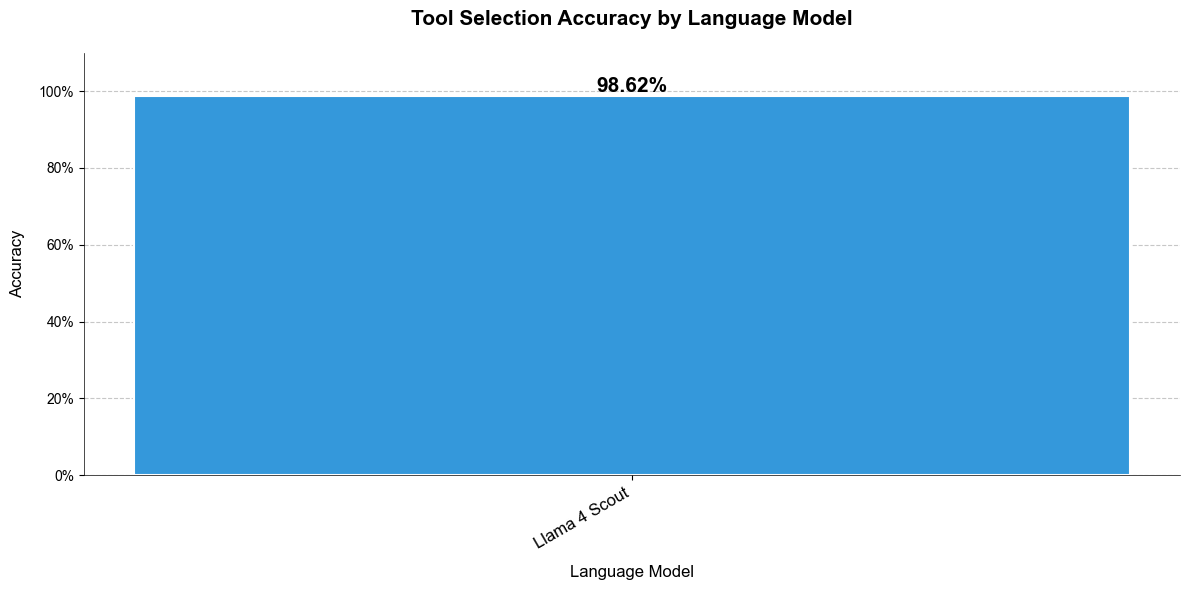

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Set the style
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate mean accuracy
mean_accuracy = result_data_df.groupby('llm_name')['tool_chosen_correctly'].mean().sort_values()

# Custom colors with higher saturation
colors = ['#3498db', '#2ecc71']  # Vibrant blue and green

# Create bars
bars = ax.bar(
    mean_accuracy.index,
    mean_accuracy.values,
    color=colors,
    width=0.6,
    edgecolor='white',
    linewidth=1.5
)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2.,
        height,
        f'{height:.2%}',
        ha='center',
        va='bottom',
        fontsize=15,
        fontweight='bold'
    )

# Customize the plot
ax.set_title('Tool Selection Accuracy by Language Model', 
             pad=20, 
             fontsize=15, 
             fontweight='bold')
ax.set_xlabel('Language Model', fontsize=12, labelpad=10)
ax.set_ylabel('Accuracy', fontsize=12, labelpad=10)

# Customize grid
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)  # Place gridlines behind bars

# Customize spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Set y-axis limits with some padding
ax.set_ylim(0, min(1.1, max(mean_accuracy.values) * 1.15))

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
# Rotate x-axis labels
ax.set_xticklabels(mean_accuracy.index, rotation=30, ha='right', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.savefig('tool_acc.png', dpi=1000)

## Precision/Recall

In [26]:
# Initialize a list to collect results
metrics = []

import itertools

# Get unique values for llm_name and correct_tool_name
llm_names = result_data_df['llm_name'].unique()
correct_tool_names = result_data_df['correct_tool_name'].unique()

# Use itertools.product to generate all combinations
all_combinations = list(itertools.product(llm_names, correct_tool_names))

# Now, iterate through combinations and get data for each
results = []

for llm_name, tool_name in all_combinations:
    group = result_data_df[result_data_df['llm_name'] == llm_name]

    # True Negatives: Tool was not chosen correctly
    true_negatives = len(group[(group['chosen_tool_name'] != tool_name) & (group['correct_tool_name'] != tool_name)])
    
    # True Positives: Tool was chosen correctly
    true_positives = len(group[(group['chosen_tool_name'] == tool_name) & (group['tool_chosen_correctly'] == True)])
    
    # False Positives: Tool was chosen incorrectly
    false_positives = len(group[(group['chosen_tool_name'] == tool_name) & (group['tool_chosen_correctly'] == False)])

    # False Negatives: Tool was correct but not chosen
    false_negatives = len(group[(group['chosen_tool_name'] != tool_name) & (group['correct_tool_name'] == tool_name)])

    # Calculate precision and recall
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    accuracy = (true_positives + true_negatives) / (true_negatives + true_positives + false_positives + false_negatives)

    # Append results to the list
    metrics.append({
        'llm_name': llm_name,
        'tool_name': tool_name,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy
    })

In [27]:
len(metrics)

5

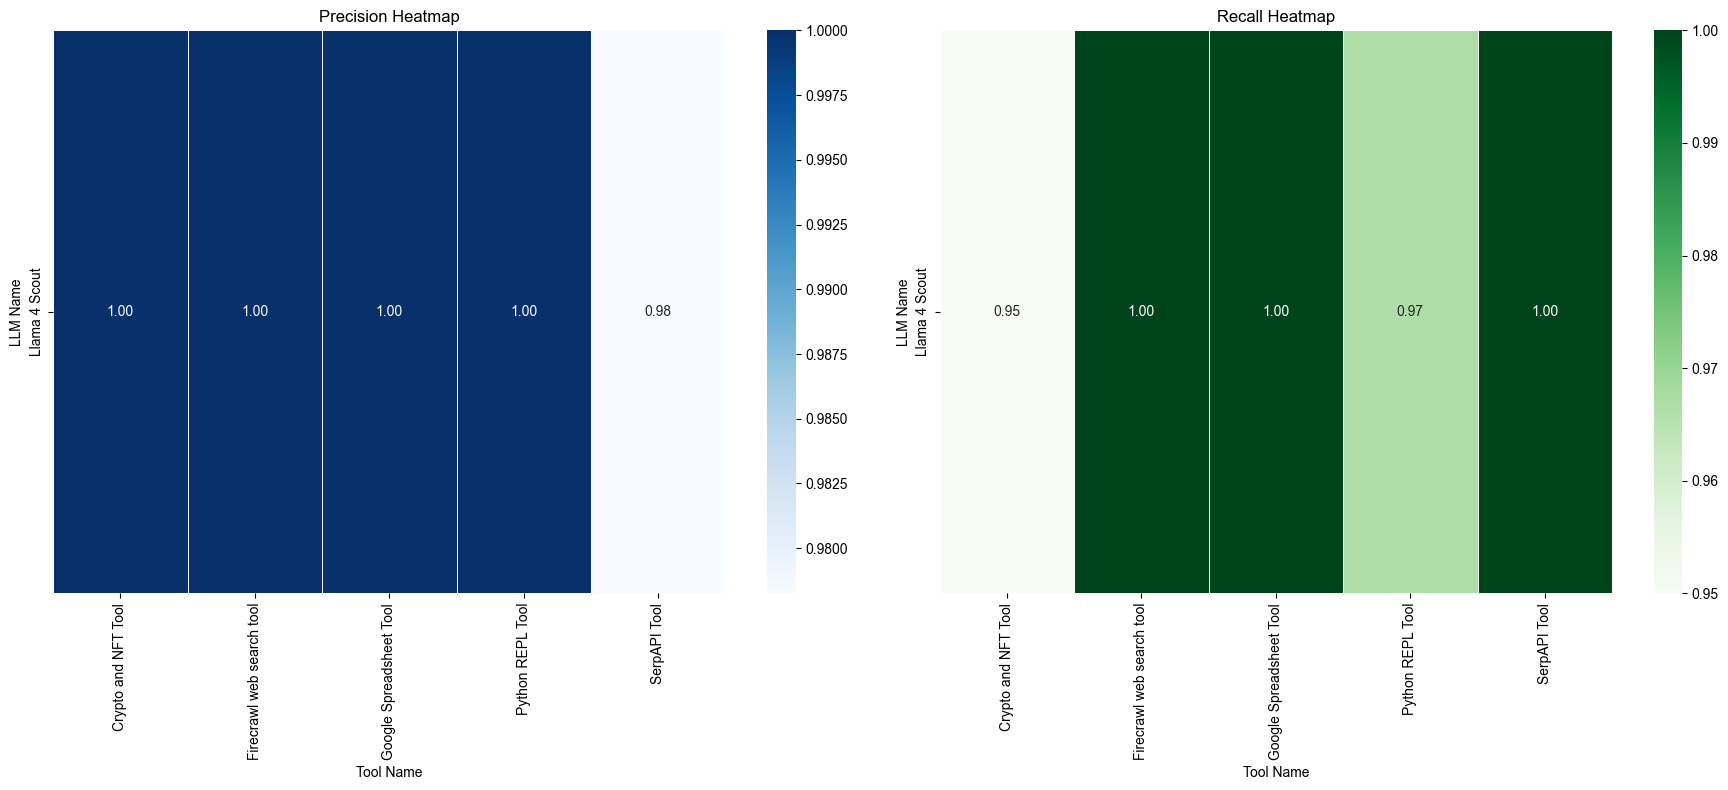

In [28]:
# Create a DataFrame from the results
metrics_df = pd.DataFrame(metrics)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the DataFrame (metrics_df should already be defined)
metrics_df = pd.DataFrame(metrics)

# Aggregate by calculating the mean precision and recall for each (llm_name, tool_name) pair
metrics_df = metrics_df.groupby(['llm_name', 'tool_name']).mean().reset_index()

# Pivot the DataFrame for heatmaps
precision_pivot = metrics_df.pivot(index='llm_name', columns='tool_name', values='precision')
recall_pivot = metrics_df.pivot(index='llm_name', columns='tool_name', values='recall')

# Set up the figure for subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Precision Heatmap
sns.heatmap(precision_pivot, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5, ax=axes[0])
axes[0].set_title('Precision Heatmap')
axes[0].set_xlabel('Tool Name')
axes[0].set_ylabel('LLM Name')

# Recall Heatmap
sns.heatmap(recall_pivot, annot=True, cmap='Greens', fmt='.2f', linewidths=0.5, ax=axes[1])
axes[1].set_title('Recall Heatmap')
axes[1].set_xlabel('Tool Name')
axes[1].set_ylabel('LLM Name')

# Adjust layout
plt.tight_layout()
plt.savefig('p_r_tool.png', dpi=1000)
plt.show()

In [29]:
# Adding weights for each sample based on the number of samples per (llm_name, tool_name) pair

# Simulating a count column for weights (assuming a random sample size for demonstration)
import numpy as np

# Adding a random sample count for demonstration purposes
metrics_df['sample_count'] = np.random.randint(5, 20, size=len(metrics_df))

# Calculating weighted precision and recall
metrics_df['weighted_precision'] = metrics_df['precision'] * metrics_df['sample_count']
metrics_df['weighted_recall'] = metrics_df['recall'] * metrics_df['sample_count']

# Group by LLM name to aggregate and calculate the weighted averages
llm_weighted_metrics = metrics_df.groupby('llm_name').apply(
    lambda x: pd.Series({
        'weighted_precision': x['weighted_precision'].sum() / x['sample_count'].sum(),
        'weighted_recall': x['weighted_recall'].sum() / x['sample_count'].sum(),
    })
).reset_index()

# Melt the DataFrame for plotting
llm_weighted_melted = llm_weighted_metrics.melt(id_vars=['llm_name'], value_vars=['weighted_precision', 'weighted_recall'],
                                                var_name='Metric', value_name='Score')

# Calculate F1 score for each LLM based on weighted precision and recall
llm_weighted_metrics['f1_score'] = 2 * (
    llm_weighted_metrics['weighted_precision'] * llm_weighted_metrics['weighted_recall']
) / (llm_weighted_metrics['weighted_precision'] + llm_weighted_metrics['weighted_recall'])

# Sort by increasing F1 score
llm_weighted_metrics_sorted = llm_weighted_metrics.sort_values(by='f1_score').reset_index(drop=True)


/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_31774/3573547475.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  llm_weighted_metrics = metrics_df.groupby('llm_name').apply(


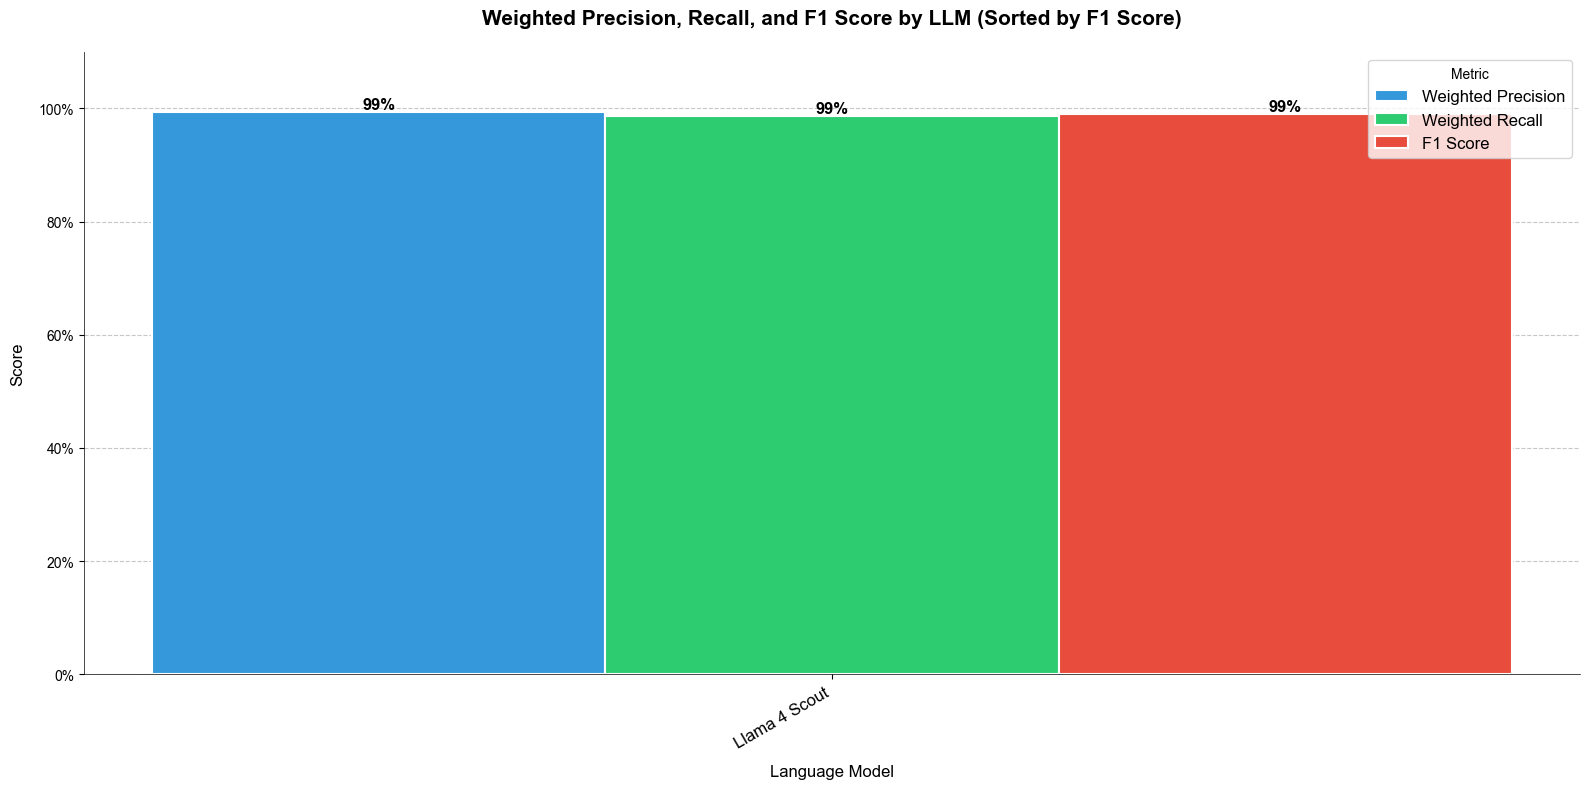

In [30]:
# Increase spacing between groups by adjusting the bar width and x locations
fig, ax = plt.subplots(figsize=(16, 8))

# Define bar width and spacing
bar_width = .2
spacing = 0.2
x = np.arange(len(llm_weighted_metrics_sorted['llm_name'])) * (bar_width * 3 + spacing)

# Create bars with increased space between groups
bars_precision = ax.bar(
    x - bar_width, llm_weighted_metrics_sorted['weighted_precision'],
    color='#3498db', width=bar_width, edgecolor='white', linewidth=1.5, label='Weighted Precision'
)

bars_recall = ax.bar(
    x, llm_weighted_metrics_sorted['weighted_recall'],
    color='#2ecc71', width=bar_width, edgecolor='white', linewidth=1.5, label='Weighted Recall'
)

bars_f1 = ax.bar(
    x + bar_width, llm_weighted_metrics_sorted['f1_score'],
    color='#e74c3c', width=bar_width, edgecolor='white', linewidth=1.5, label='F1 Score'
)

# Add value labels on top of each bar
for bars in [bars_precision, bars_recall, bars_f1]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height,
            f'{height:.0%}',
            ha='center',
            va='bottom',
            fontsize=12,
            fontweight='bold'
        )

# Customize the plot
ax.set_title('Weighted Precision, Recall, and F1 Score by LLM (Sorted by F1 Score)', 
             pad=20, fontsize=15, fontweight='bold')
ax.set_xlabel('Language Model', fontsize=12, labelpad=10)
ax.set_ylabel('Score', fontsize=12, labelpad=10)
ax.set_xticks(x)
ax.set_xticklabels(llm_weighted_metrics_sorted['llm_name'], rotation=30, ha='right', fontsize=12)

# Customize grid and spines
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Set y-axis limits with padding
ax.set_ylim(0, 1.1)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Add legend
ax.legend(title='Metric', fontsize=12)

# Adjust layout with more space
plt.tight_layout()
plt.show()


# Positional Bias

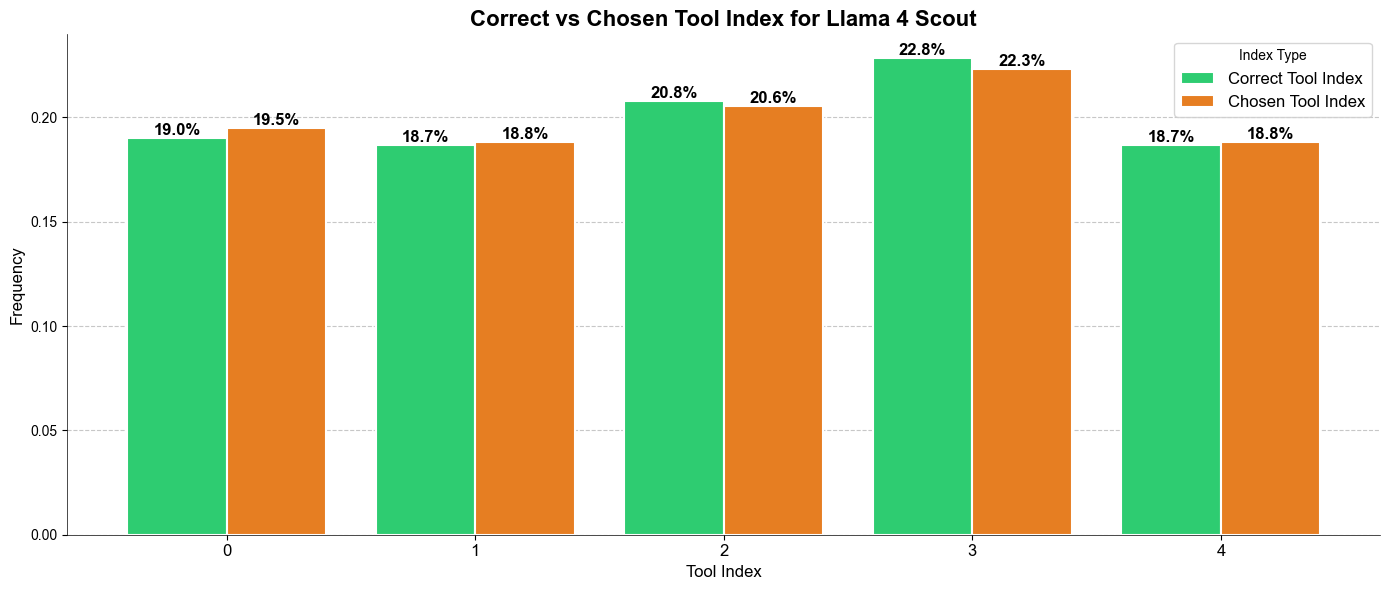

In [31]:
import matplotlib.pyplot as plt
model_choices = {}

# Define the model name
for MODEL_NAME in result_data_df['llm_name'].unique():
    
    # Filter the results for the specified model
    llm_results = result_data_df[result_data_df['llm_name'] == MODEL_NAME]
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Define bar width and x-axis locations
    bar_width = 0.4
    x = np.arange(len(llm_results['correct_tool_index'].unique()) )
    
    # Aggregate the data for plotting
    correct_counts = llm_results['correct_tool_index'].value_counts(normalize=True).sort_index()
    chosen_counts = llm_results['chosen_tool_index'].value_counts(normalize=True).sort_index()
    
    # Align indices
    correct_counts = correct_counts.reindex(x, fill_value=0)
    chosen_counts = chosen_counts.reindex(x, fill_value=0)

    model_choices[MODEL_NAME] = ((chosen_counts - correct_counts) / correct_counts)
    
    # Plot side-by-side bars with new colors
    bars_correct = ax.bar(
        x - bar_width / 2, correct_counts, width=bar_width, color='#2ecc71', edgecolor='white', linewidth=1.5, label='Correct Tool Index'
    )
    
    bars_chosen = ax.bar(
        x + bar_width / 2, chosen_counts, width=bar_width, color='#e67e22', edgecolor='white', linewidth=1.5, label='Chosen Tool Index'
    )
    
    # Add value labels on top of each bar
    for bars in [bars_correct, bars_chosen]:
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.,
                height,
                f'{round(height * 100, 1)}%',
                ha='center',
                va='bottom',
                fontsize=12,
                fontweight='bold'
            )
    
    # Customize the plot
    ax.set_title(f'Correct vs Chosen Tool Index for {MODEL_NAME}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Tool Index', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(x, fontsize=12)
    
    # Customize grid and spines
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    # Add legend
    ax.legend(title='Index Type', fontsize=12)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


In [32]:
def plot_pos_bias(proportion_data, title):  # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Define colors based on positive/negative values
    colors = ['#2ecc71' if val >= 0 else '#e74c3c' for val in proportion_data]
    
    # Plot bar chart
    bars = ax.bar(proportion_data.index, proportion_data.values, color=colors, edgecolor='white', linewidth=1.5)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height,
            f'{height:.2%}',
            ha='center',
            va='bottom' if height >= 0 else 'top',
            fontsize=12,
            fontweight='bold',
            color='black'
        )
    
    # Customize the plot
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel('Correct Tool Index', fontsize=12)
    ax.set_ylabel('Average Proportion (Chosen - Correct / Correct)', fontsize=12)
    
    # Customize grid and spines
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    # Set y-axis limits for better visualization
    ax.set_ylim(min(proportion_data.values) - 0.05, max(proportion_data.values) + 0.05)
    
    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig(f'pos_bias_tool_{title}.png', dpi=1000)
    plt.show()


## Average of all models

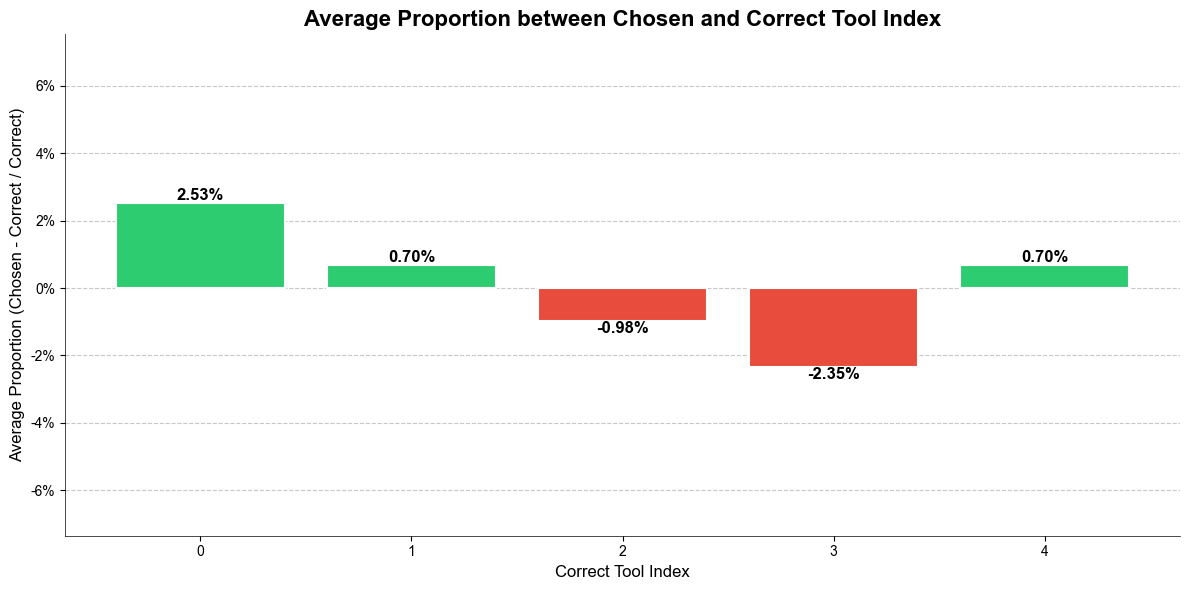

In [33]:
# Assuming model_choices is your list of Series
proportion_data = pd.concat([v for k, v in model_choices.items()], axis=1).mean(axis=1)
plot_pos_bias(proportion_data, 'Average Proportion between Chosen and Correct Tool Index')

In [34]:
model_choices.keys()

dict_keys(['Llama 4 Scout'])

## Closed Source Chat Bias

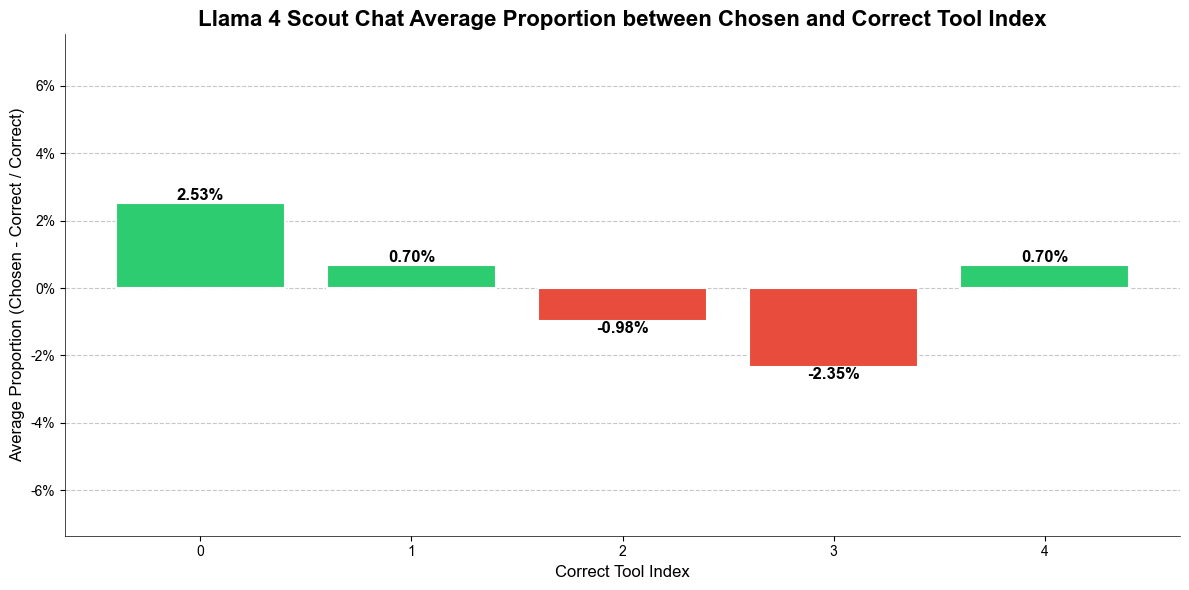

In [38]:
# Assuming model_choices is your list of Series
proportion_data = pd.concat([v for k, v in model_choices.items() if 'Llama 4' in k], axis=1).mean(axis=1)
plot_pos_bias(proportion_data, 'Llama 4 Scout Chat Average Proportion between Chosen and Correct Tool Index')